In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, random_split
from fastai.data.core import DataLoaders
import torch.nn as nn
from fastai.learner import Learner
from fastai.metrics import accuracy
from fastai.losses import CrossEntropyLossFlat
from torch.utils.data import TensorDataset, random_split, DataLoader
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.nn as nn
from fastai.learner import Learner
from fastai.losses import CrossEntropyLossFlat
from fastai.metrics import accuracy
import random
from fastai.callback.tracker import EarlyStoppingCallback


torch.manual_seed(42)
np.random.seed(42)
random.seed(42)



df = yf.download("^GSPC", start="2000-01-01")

/tmp/ipython-input-2668286915.py:32: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("^GSPC", start="2000-01-01")
[*********************100%***********************]  1 of 1 completed


In [2]:
df.head()

Price,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,
2000-01-03,1455.219971,1478.000000,1438.359985,1469.250000,931800000
2000-01-04,1399.420044,1455.219971,1397.430054,1455.219971,1009000000
2000-01-05,1402.109985,1413.270020,1377.680054,1399.420044,1085500000
2000-01-06,1403.449951,1411.900024,1392.099976,1402.109985,1092300000
2000-01-07,1441.469971,1441.469971,1400.729980,1403.449951,1225200000


Elimine un nivel del índice de columnas generado por yfinance

In [3]:
df.columns = df.columns.droplevel(1)



Obtenemos el retorno logarítmico del día usando el cierre de hoy dividido entre el de ayer. Quito la primera fila porque no puede calcularse su retorno (queda como NaN)

In [4]:
df['log_ret'] = np.log(df['Close'] / df['Close'].shift(1))

df = df.dropna(subset=['log_ret'])

In [5]:
df.head()

Price,Close,High,Low,Open,Volume,log_ret
Date,,,,,,
2000-01-04,1399.420044,1455.219971,1397.430054,1455.219971,1009000000,-0.039099
2000-01-05,1402.109985,1413.270020,1377.680054,1399.420044,1085500000,0.001920
2000-01-06,1403.449951,1411.900024,1392.099976,1402.109985,1092300000,0.000955
2000-01-07,1441.469971,1441.469971,1400.729980,1403.449951,1225200000,0.026730
2000-01-10,1457.599976,1464.359985,1441.469971,1441.469971,1064800000,0.011128


Agregamos label

Aqui calculo la volatilidad futura. Es la desviación estandar de los próximos 10 días.

Don shift(-10) muevo ese valor hacia arriba para que corresponda al día donde quiero predecir

Para esta etapa recurrí a asistencia técnica de ChatGPT con el fin de validar que la ventana de días futuros estuviera correctamente alineada con el instante temporal t. Esta comprobación era esencial, ya que cualquier desalineación en la volatilidad futura afectaría directamente la generación de etiquetas y, por lo tanto, el desempeño del modelo.

In [6]:
window_vol = 10

# Volatilidad futura, std de los próximos N días
df['rv_future'] = df['log_ret'].rolling(window_vol).std().shift(-window_vol)

print(df['rv_future'])

Date
2000-01-04    0.011474
2000-01-05    0.011996
2000-01-06    0.012133
2000-01-07    0.012418
2000-01-10    0.011876
                ...   
2025-11-26         NaN
2025-11-28         NaN
2025-12-01         NaN
2025-12-02         NaN
2025-12-03         NaN
Name: rv_future, Length: 6519, dtype: float64


Calculo el umbral

In [7]:
threshold = df['rv_future'].median()
print(threshold)

0.008325207617525083


Generación del label y limpieza de NaN


In [8]:
df['label'] = (df['rv_future'] > threshold).astype(int)

df = df.dropna(subset=['rv_future'])

Total de 0 y 1

In [9]:
df['label'].value_counts()

,count
label,
0,3255
1,3254


In [10]:
df.head()

Price,Close,High,Low,Open,Volume,log_ret,rv_future,label
Date,,,,,,,,
2000-01-04,1399.420044,1455.219971,1397.430054,1455.219971,1009000000,-0.039099,0.011474,1
2000-01-05,1402.109985,1413.270020,1377.680054,1399.420044,1085500000,0.001920,0.011996,1
2000-01-06,1403.449951,1411.900024,1392.099976,1402.109985,1092300000,0.000955,0.012133,1
2000-01-07,1441.469971,1441.469971,1400.729980,1403.449951,1225200000,0.026730,0.012418,1
2000-01-10,1457.599976,1464.359985,1441.469971,1441.469971,1064800000,0.011128,0.011876,1


In [11]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=df)

https://docs.google.com/spreadsheets/d/1vULomoSA1wc07O2IEa8CRe6h_UR419cMBoj0a1XFfrs/edit#gid=0


In [12]:
df.describe()

Price,Close,High,Low,Open,Volume,log_ret,rv_future,label
count,6509.000000,6509.000000,6509.000000,6509.000000,6.509000e+03,6509.000000,6509.000000,6509.000000
mean,2248.814759,2261.320538,2234.620184,2248.478699,3.413252e+09,0.000233,0.010126,0.499923
std,1425.332964,1431.619479,1417.896291,1425.062347,1.512048e+09,0.012234,0.007124,0.500038
min,676.530029,695.270020,666.789978,679.280029,0.000000e+00,-0.127652,0.001459,0.000000
25%,1209.569946,1215.689941,1200.739990,1209.469971,2.301860e+09,-0.004757,0.005767,0.000000
50%,1520.770020,1529.390015,1514.140015,1520.770020,3.525160e+09,0.000634,0.008325,0.000000
75%,2878.199951,2891.110107,2860.709961,2876.090088,4.252100e+09,0.005872,0.012162,1.000000
max,6890.890137,6920.339844,6870.729980,6910.950195,1.145623e+10,0.109572,0.075383,1.000000


Análisis

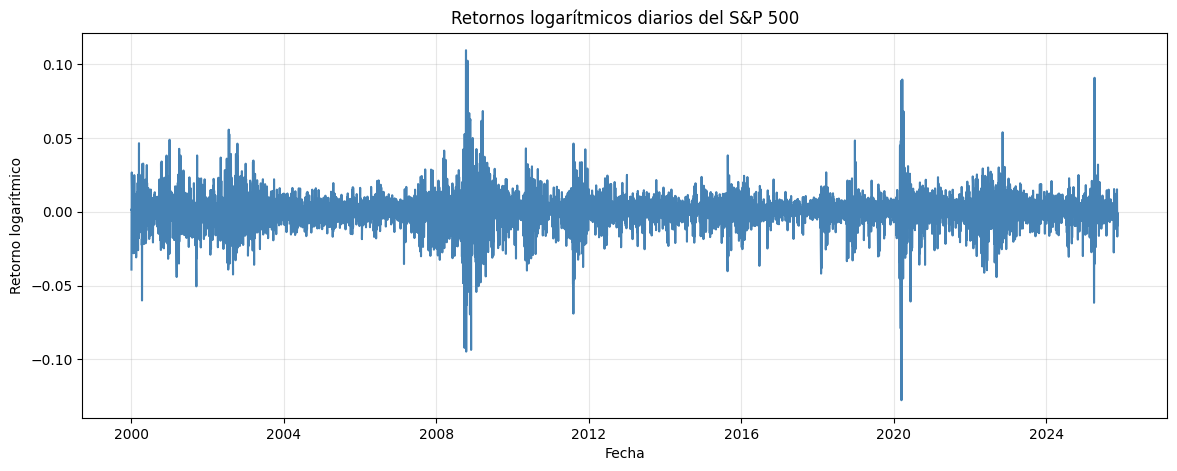

In [13]:
plt.figure(figsize=(14,5))
plt.plot(df['log_ret'], color='steelblue')
plt.title('Retornos logarítmicos diarios del S&P 500')
plt.xlabel('Fecha')
plt.ylabel('Retorno logarítmico')
plt.grid(True, alpha=0.3)
plt.show()

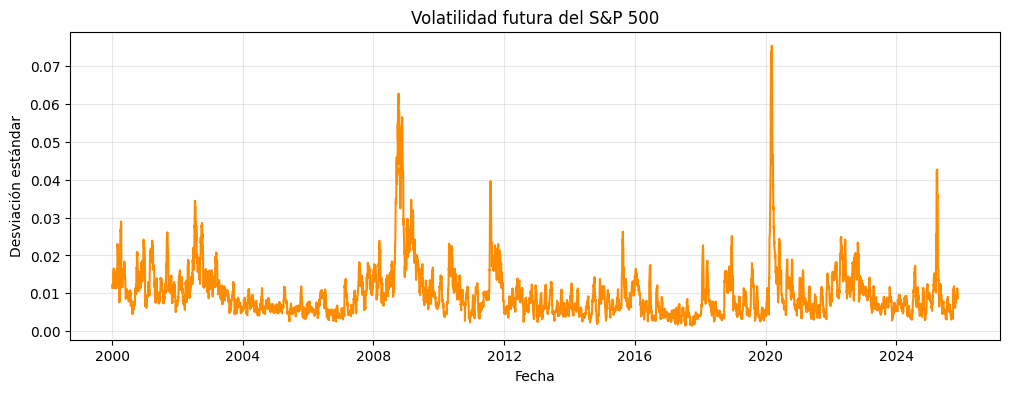

In [14]:
plt.figure(figsize=(12,4))
plt.plot(df['rv_future'], color='darkorange')
plt.title('Volatilidad futura del S&P 500')
plt.xlabel('Fecha')
plt.ylabel('Desviación estándar')
plt.grid(alpha=0.3)
plt.show()

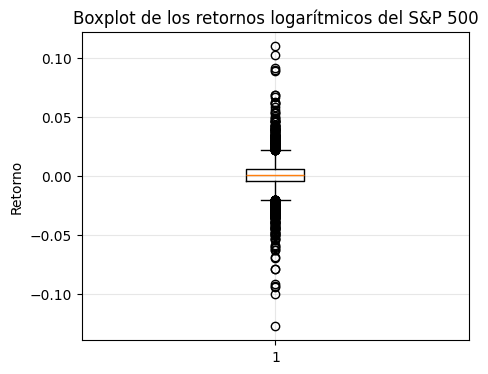

In [15]:
plt.figure(figsize=(5,4))
plt.boxplot(df['log_ret'], vert=True)
plt.title('Boxplot de los retornos logarítmicos del S&P 500')
plt.ylabel('Retorno')
plt.grid(alpha=0.3)
plt.show()

Baseline

In [16]:
import random
random.seed(42)

In [17]:
df['ret_1'] = df['log_ret'].shift(1)
df.head()

Price,Close,High,Low,Open,Volume,log_ret,rv_future,label,ret_1
Date,,,,,,,,,
2000-01-04,1399.420044,1455.219971,1397.430054,1455.219971,1009000000,-0.039099,0.011474,1,NaN
2000-01-05,1402.109985,1413.270020,1377.680054,1399.420044,1085500000,0.001920,0.011996,1,-0.039099
2000-01-06,1403.449951,1411.900024,1392.099976,1402.109985,1092300000,0.000955,0.012133,1,0.001920
2000-01-07,1441.469971,1441.469971,1400.729980,1403.449951,1225200000,0.026730,0.012418,1,0.000955
2000-01-10,1457.599976,1464.359985,1441.469971,1441.469971,1064800000,0.011128,0.011876,1,0.026730


In [18]:
df['ret_2'] = df['log_ret'].shift(2)
df['ret_3'] = df['log_ret'].shift(3)
df['ret_4'] = df['log_ret'].shift(4)
df['vol_5'] = df['log_ret'].rolling(5).std()

base_df = df.dropna()

In [19]:
df.head()


Price,Close,High,Low,Open,Volume,log_ret,rv_future,label,ret_1,ret_2,ret_3,ret_4,vol_5
Date,,,,,,,,,,,,,
2000-01-04,1399.420044,1455.219971,1397.430054,1455.219971,1009000000,-0.039099,0.011474,1,NaN,NaN,NaN,NaN,NaN
2000-01-05,1402.109985,1413.270020,1377.680054,1399.420044,1085500000,0.001920,0.011996,1,-0.039099,NaN,NaN,NaN,NaN
2000-01-06,1403.449951,1411.900024,1392.099976,1402.109985,1092300000,0.000955,0.012133,1,0.001920,-0.039099,NaN,NaN,NaN
2000-01-07,1441.469971,1441.469971,1400.729980,1403.449951,1225200000,0.026730,0.012418,1,0.000955,0.001920,-0.039099,NaN,NaN
2000-01-10,1457.599976,1464.359985,1441.469971,1441.469971,1064800000,0.011128,0.011876,1,0.026730,0.000955,0.001920,-0.039099,0.024347


In [20]:
base_df.head()

Price,Close,High,Low,Open,Volume,log_ret,rv_future,label,ret_1,ret_2,ret_3,ret_4,vol_5
Date,,,,,,,,,,,,,
2000-01-10,1457.599976,1464.359985,1441.469971,1441.469971,1064800000,0.011128,0.011876,1,0.026730,0.000955,0.001920,-0.039099,0.024347
2000-01-11,1438.560059,1458.660034,1434.420044,1457.599976,1014000000,-0.013149,0.011380,1,0.011128,0.026730,0.000955,0.001920,0.014694
2000-01-12,1432.250000,1442.599976,1427.079956,1438.560059,974600000,-0.004396,0.011373,1,-0.013149,0.011128,0.026730,0.000955,0.015338
2000-01-13,1449.680054,1454.199951,1432.250000,1432.250000,1030400000,0.012096,0.012663,1,-0.004396,-0.013149,0.011128,0.026730,0.015546
2000-01-14,1465.150024,1473.000000,1449.680054,1449.680054,1085900000,0.010615,0.015321,1,0.012096,-0.004396,-0.013149,0.011128,0.011423


In [21]:
X_base = base_df[['ret_1', 'ret_2', 'ret_3', 'ret_4','vol_5']]
y_base = base_df['label']

In [22]:
X_train, X_val, y_train, y_val = train_test_split(X_base, y_base, test_size=0.2, shuffle=False)

clf = LogisticRegression()
clf.fit(X_train, y_train)

preds = clf.predict(X_val)
acc = accuracy_score(y_val, preds)
print("Accuracy:", acc)

Accuracy: 0.6402767102229054


Red Neuronal

Creamos las secuencias para la red


In [23]:
window_size = 60

def create_sequences(df, window_size=60):
    X, y = [], []
    log_rets = df['log_ret'].values
    labels   = df['label'].values

    for i in range(len(df) - window_size):
        seq = log_rets[i:i+window_size]      # 60 días pasados
        X.append(seq)
        y.append(labels[i+window_size])

    X = np.array(X)
    y = np.array(y)
    return X, y

X, y = create_sequences(df, window_size)
X.shape, y.shape

((6449, 60), (6449,))

In [30]:
df.head()

Price,Close,High,Low,Open,Volume,log_ret,rv_future,label,ret_1,ret_2,ret_3,ret_4,vol_5
Date,,,,,,,,,,,,,
2000-01-04,1399.420044,1455.219971,1397.430054,1455.219971,1009000000,-0.039099,0.011474,1,NaN,NaN,NaN,NaN,NaN
2000-01-05,1402.109985,1413.270020,1377.680054,1399.420044,1085500000,0.001920,0.011996,1,-0.039099,NaN,NaN,NaN,NaN
2000-01-06,1403.449951,1411.900024,1392.099976,1402.109985,1092300000,0.000955,0.012133,1,0.001920,-0.039099,NaN,NaN,NaN
2000-01-07,1441.469971,1441.469971,1400.729980,1403.449951,1225200000,0.026730,0.012418,1,0.000955,0.001920,-0.039099,NaN,NaN
2000-01-10,1457.599976,1464.359985,1441.469971,1441.469971,1064800000,0.011128,0.011876,1,0.026730,0.000955,0.001920,-0.039099,0.024347


In [32]:
df['label'].value_counts()

,count
label,
0,3255
1,3254


Pasamos a tensores y hacemos el train/valid

Chat Prompot = 'Me ayudas a separar mis datos de prueba y validacion para el entrenamiento de la CNN1D'

In [24]:
# (n_samples, 60) -> (n_samples, 1, 60) para Conv1d
X_t = torch.tensor(X, dtype=torch.float32).unsqueeze(1)
y_t = torch.tensor(y, dtype=torch.long)

dataset = TensorDataset(X_t, y_t)

# 80% train, 20% valid
n = len(dataset)
n_train = int(0.8 * n)
n_valid = n - n_train

train_ds, valid_ds = random_split(dataset, [n_train, n_valid])

batch_size = 64

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=False)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)

In [25]:
from fastai.data.core import DataLoaders

dls = DataLoaders(train_dl, valid_dl)


Definimos la CNN 1D

Chat, tengo un batch size de 64 y una ventana temporal de 60 días. Ajusta una arquitectura CNN 1D basada en la tabla que te mando (Conv1D → ReLU → MaxPool → Conv1D -> ReLU -> MaxPool -> Dense), pero simplificada para mi problema de clasificación binaria. Respeta la estructura general de la tabla, pero adapta el número de parámetros a mis dimensiones (n_samples, 1, 60). Dame el modelo en PyTorch listo para usar.

Al final, a partir la versión base de ChatGPT la CNN1D hice algunos ajustes extra: aumenté el número de filtros en las capas convolucionales y añadí una capa de dropout (p = 0.3) antes de la capa totalmente conectada. Estos cambios buscan mejorar la capacidad del modelo para capturar patrones más complejos en la serie y, al mismo tiempo, reducir el sobreajuste, lo que en la práctica se tradujo en una ligera mejora del desempeño en el conjunto de validación.

In [26]:
class CNN1D(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=5, padding=2)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(2)

        self.conv2 = nn.Conv1d(64, 128, kernel_size=7, padding=3)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(2)

        self.dropout = nn.Dropout(p=0.3)
        self.gap = nn.AdaptiveAvgPool1d(1)
        self.fc  = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.dropout(x)
        x = self.gap(x).squeeze(-1)
        return self.fc(x)

Learner

In [27]:
model = CNN1D()

learn = Learner(
    dls, model,
    loss_func=CrossEntropyLossFlat(),
    metrics=accuracy,
    wd=1e-2,
    cbs=EarlyStoppingCallback(monitor='valid_loss', patience=5)
)

learn.fit(100, lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.693024,0.692887,0.501550,00:03
1,0.690884,0.688850,0.524031,00:02
2,0.683511,0.672883,0.613178,00:02
3,0.661016,0.633041,0.728682,00:02
4,0.623968,0.591149,0.720155,00:02
5,0.590379,0.564452,0.721705,00:03
6,0.568232,0.550904,0.722481,00:02
7,0.556206,0.544979,0.723256,00:02
8,0.550259,0.540948,0.723256,00:02
9,0.545924,0.538365,0.724031,00:03


Graficar loss

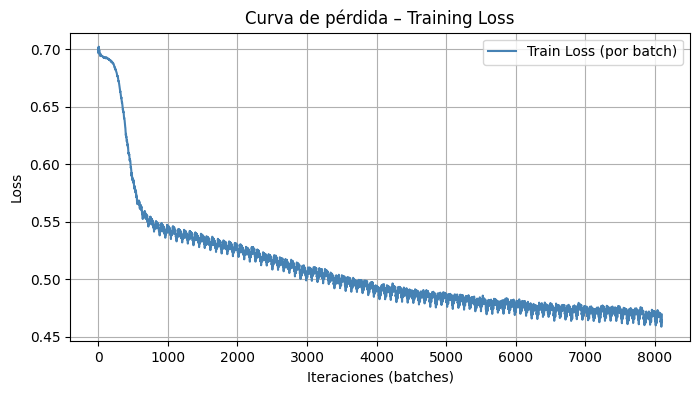

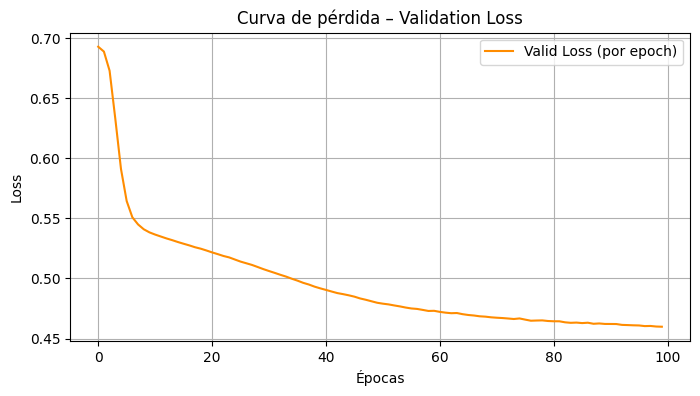

In [28]:
train_loss = [float(loss) for loss in learn.recorder.losses]

val_loss = [v[1] for v in learn.recorder.values]

# Training Loss
plt.figure(figsize=(8,4))
plt.plot(train_loss, label="Train Loss (por batch)", color='steelblue')
plt.xlabel("Iteraciones (batches)")
plt.ylabel("Loss")
plt.title("Curva de pérdida – Training Loss")
plt.grid(True)
plt.legend()
plt.show()

# Validation Loss
plt.figure(figsize=(8,4))
plt.plot(val_loss, label="Valid Loss (por epoch)", color='darkorange')
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.title("Curva de pérdida – Validation Loss")
plt.grid(True)
plt.legend()
plt.show()